In [1]:
from __future__ import division
import sys
import numpy as np
import operator
from numpy import ma
from scipy.interpolate import griddata
import pyshtools
from pyshtools import expand
import math
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [2]:
def w_propmat_sph_pyshtools(fname, header, clm):
     """
     sghelichkhani:
     Write out  the spherical harmonics coefficients produced by
        geoid code A
        """
     out_fi = open(name=fname, mode='w')
     out_fi.write('# lmax = %2.2i\n' %clm.lmax)
     out_fi.write('# %s\n' %header)
     for l in range(clm.lmax+1):
        for m in range(l+1):
           out_fi.write("SPHCO %3i %3i %14.6e %14.6e\n"\
                 %(l, m, clm.coeffs[0,l,m], clm.coeffs[1,l,m]));
     out_fi.close()

def grd_reshape_for_pyshtools(lon, lat, data):
     """
     sghelichkhani:
        Convert a grid of -180 to 180 grid to
        a grid starting from 0 going to 360
        Needed when converting grid to sph using pyshtools

     old_lon= lon between -180 to 180
     old_lat does not change,
     old_data[old_lon, old_lat] -> new_data[new_lon, new_lat]
     new_lon, new_lat, new_data =
              grd_reshape_for_pyshtools(old_lon, old_lat, old_data)
     """
     import numpy as np
     null_index = abs(lon - 0.0).argmin()
     new_lon =np.concatenate((lon[null_index:],lon[1:null_index]),axis=0)
     new_lon[new_lon<0.0] += 360.
     new_lat = np.flipud(lat[1:])
     new_data =	np.concatenate((data[:-1,null_index:],data[:-1,1:null_index]),axis=1)
     new_data = np.flipud(new_data)

     return new_lon, new_lat, new_data


def geocentric2sph(lon,lat,value,lmax):
     """
       Siavash Ghelichkhan, sghelichkhani@geophysik.uni-muenchen.de
       Using the available libraries for python, read in a grid, and
convert
       it to spherical harmonic coefficients and write out the results
     """

     # xyz data is converted to a grid of grid_old[nx, ny]
     nx=361; ny=181;

     # find an average for the data, the points without a data are
#assigend "ave"
     ave = np.sum(value)/np.shape(value)[0]

     # longitude and latitude of the data
     old_lons = np.linspace(-180, +180,nx)
     old_lats = np.linspace(- 90, + 90,ny)
     old_lons, old_lats = np.meshgrid(old_lons, old_lats)

     # convert the xyz to a grid of [old_lons, old_lats]
     #grid_old = mlab.griddata(lon, lat, value, old_lons, old_lats,
#interp='linear')
     value = griddata((lon, lat), value, (old_lons, old_lats), 
                method='linear').reshape(old_lons.shape)


     # set the point without a value to ave
     #grid_old.data[grid_old.mask] = ave
     value = ma.masked_where(np.isnan(value),value)
     value = ma.filled(value,fill_value=ave)

     old_lons = np.linspace(-180, +180,nx)
     old_lats = np.linspace(-90, +90,ny)
     # reshape data from -180-180 to 0-360, for pyshtools
     new_lons, new_lats, new_grid = grd_reshape_for_pyshtools(old_lons,
            old_lats, value)
     
#     with open("newgrid.txt","w") as f:
#        for item in new_grid:
#            f.write("%s\n" %item)
#     f.close()
 
     # initialize the pyshtools.GRID
     grid = pyshtools.SHGrid.from_array(new_grid);
     
     #if new_lons!=grid.lons() or new_lats!=grid.lats():
     #   sys.exit('Error: lons/lats defined by pyshtools and the input
#lons/lats do not match');
     # convert grid to spherical harmonics
     clm = grid.expand(normalization='4pi', lmax_calc= lmax)

     return clm

def variance(clm,lmax=15):
     power = list()

     for l in range(1,clm.lmax+1):
        var = 0.0
        for m in range(l+1):
           var += (clm.coeffs[0,l,m])**2 + (clm.coeffs[1,l,m])**2
        power.append(var)

     return np.asarray(power)

def correlation(clm_fcst, clm_ref, lmax):
    corr_list = list()
    
    for l in range(1, clm_fcst.lmax+1):
        var_ref = 0.0
        var_fcst = 0.0
        cov_ref_fcst = 0.0
        for m in range(l+1):
            var_ref += (clm_ref.coeffs[0,l,m])**2 + (clm_ref.coeffs[1,l,m])**2
            var_fcst += (clm_fcst.coeffs[0,l,m])**2 + (clm_fcst.coeffs[1,l,m])**2
            cov_ref_fcst += clm_ref.coeffs[0,l,m]*clm_fcst.coeffs[0,l,m] +\
                            clm_ref.coeffs[1,l,m]*clm_fcst.coeffs[1,l,m]
        std_ref_fcst = math.sqrt(var_ref*var_fcst)
        corr = cov_ref_fcst / std_ref_fcst
        corr_list.append(corr)
    return corr_list

def readin(path):
    lon = np.loadtxt(path)[:,0]
    lat = np.loadtxt(path)[:,1]
    result = np.loadtxt(path)[:,2]
    pos_res = np.where(result < 0, 0, result)
    return lon,lat,result

def reshape(data):
    lon = np.linspace(-180,+180,361)
    lat = np.linspace(-90,+90,181)
    data = data.reshape(181,361)
    new_lon, new_lat, new_data = grd_reshape_for_pyshtools(lon,lat,data)
    grid = pyshtools.SHGrid.from_array(new_data)

    return grid

def compute_sph(data,lmax=40):
        lon = np.linspace(-180,+180,361)
        lat = np.linspace(-90,+90,181)
        data = data.reshape(181,361)
        new_lon, new_lat, new_data = grd_reshape_for_pyshtools(lon,lat,data)
        grid = pyshtools.SHGrid.from_array(new_data)
        clm = grid.expand(normalization="4pi",lmax_calc=lmax)

        return clm
    
def pos_neg_topo(topo,flag=1):
#1 = uplift; 2 = subsidence
    if(flag==1):
        return (np.where(topo < 0, 0, topo))
    else:
        return(np.where(topo > 0, 0, -1*topo))

In [3]:
def plot_field(array):
   # fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))
    lat = np.linspace(89,-89,179)
    lon = np.linspace(-179,180,360)
    LON, LAT = np.meshgrid(lon,lat)
    arr = []
    for row in array:
        arr.append([])
        for j in row:
            arr[-1].append(j)
#fig, ax = plt.subplots()
    #c = ax.pcolormesh(LON,LAT,arr,cmap="turbo")

    plt.pcolormesh(LON,LAT,arr,cmap="turbo")
    #surf = ax.plot_surface(LON, LAT, array, cmap=cm.coolwarm,linewidth=0, antialiased=False)

    plt.show()

In [4]:
time = "39_00"
lon, lat, ref = readin("./018/surface"+time)
_,_,rad = readin("./021/surface"+time)
_,_,hor = readin("./019/surface"+time)
_,_,s20 = readin("./056/surface"+time)
_,_,rad_assim = readin("./023/surface"+time)
_,_,hor_assim = readin("./022/surface"+time)
_,_,s20_assim = readin("./057/surface"+time)

In [5]:
total_no_assim = ref+rad+hor+s20
#total_no_assim = ref+s20
total_assim = ref+rad_assim+hor_assim+s20_assim

as_dict = {"ref":ref,"rad":rad,"hor":hor,"s20":s20,"rad_assim":rad_assim,"hor_assim":hor_assim,
        "s20_assim":s20_assim,"total_no_assim":total_no_assim,"total_assim":total_assim}

#dictionary of variances
var_dict = dict()

for k,v in as_dict.items():
    var_dict[k] = variance(geocentric2sph(lon,lat,v,40))  #variance(compute_sph(v))
#with open("power_ratio_no_assim.txt","w") as f:
#        for item in power_ratio_no_assim:
#            f.write("%s\n" %item)
#f.close()

#with open("power_ratio_assim.txt","w") as f:
#        for item in power_ratio_assim:
#            f.write("%s\n" %item)
#f.close()

In [6]:
sum_of_var_no_assim = var_dict["ref"]+var_dict["rad"]+var_dict["hor"]+var_dict["s20"]
#sum_of_var_no_assim = var_dict["ref"]+var_dict["s20"]
sum_of_var_assim = var_dict["ref"]+var_dict["rad_assim"]+var_dict["hor_assim"]+var_dict["s20_assim"]
power_ratio_no_assim = sum_of_var_no_assim / var_dict["total_no_assim"]
power_ratio_assim = sum_of_var_assim / var_dict["total_assim"]

In [7]:
power_ratio_no_assim = np.array(power_ratio_no_assim[::-1])
power_ratio_assim = np.array(power_ratio_assim[::-1])

In [8]:
print(power_ratio_assim)
print(power_ratio_no_assim)

[0.28779474 0.27516743 0.28766913 0.27356609 0.28751716 0.27178616
 0.2873325  0.26983727 0.28710755 0.26774419 0.2868337  0.26555002
 0.28650243 0.26331705 0.28610848 0.26112406 0.28565746 0.25905945
 0.28518361 0.25721157 0.28478832 0.25566094 0.2847189  0.25448547
 0.28549513 0.25381615 0.28773206 0.25418271 0.28726433 0.26016017
 0.27256969 0.27253573 0.26178554 0.2520792  0.25601056 0.25552691
 0.25954029 0.26204414 0.30242203 0.28757686]
[2.28697264 1.64755774 2.2730482  1.56832383 2.25419771 1.4803698
 2.22857838 1.38413187 2.19366128 1.28078188 2.1460487  1.17239879
 2.08135792 1.0620427  1.99434842 0.95365633 1.87961544 0.85175173
 1.73324761 0.76093031 1.55550087 0.68543786 1.35331838 0.62921304
 1.13985203 0.59758621 0.92829942 0.60413504 0.72111356 0.63771924
 0.51103333 0.46490069 0.34293669 0.30258587 0.3002271  0.27606062
 0.29488727 0.30216631 0.49658643 0.52381339]


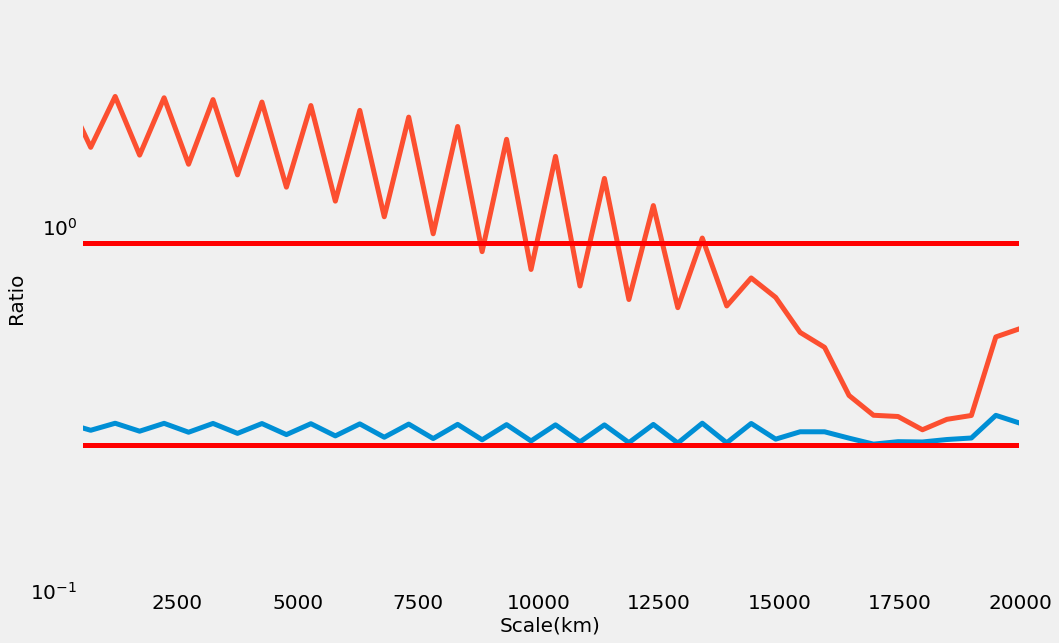

In [9]:
hor = np.linspace(200,20000,40)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)


plt.plot(hor,power_ratio_assim,linewidth=5,label="With Assimilation")
plt.plot(hor,power_ratio_no_assim,linewidth=5,label="No Assimilation")
plt.axhline(y=0.25, color='r',linewidth=5, linestyle='-',label="Ideal")

plt.grid()
#pylab.xlim([1e24,5.5e24])
plt.ylabel('Ratio',fontsize="20")
plt.xlabel('Scale(km)',fontsize="20")
plt.xticks(fontsize="20")
plt.yticks(fontsize="20")
#plt.legend(fontsize='20')
ax.set_yscale('log')
ax.set_ylim([0.1,4])
plt.axhline(y=0.9, color='r',linewidth=5,linestyle='-',label="Limit")
#ax.set_ylim(np.arange(0,1,0.9))
#ax.set_xscale('log')
ax.set_xlim([500,20000])
#plt.colorbar() 
plt.show()


In [10]:
clm_dict = dict()
for k,v in as_dict.items():
    clm_dict[k] = geocentric2sph(lon,lat,v,40)

In [11]:
corr_dict = dict()
for name, clm in clm_dict.items():
    corr_dict[name] = correlation(clm,clm_dict["ref"],40)

In [12]:
del corr_dict["total_assim"]
del corr_dict["total_no_assim"]
del corr_dict["ref"]

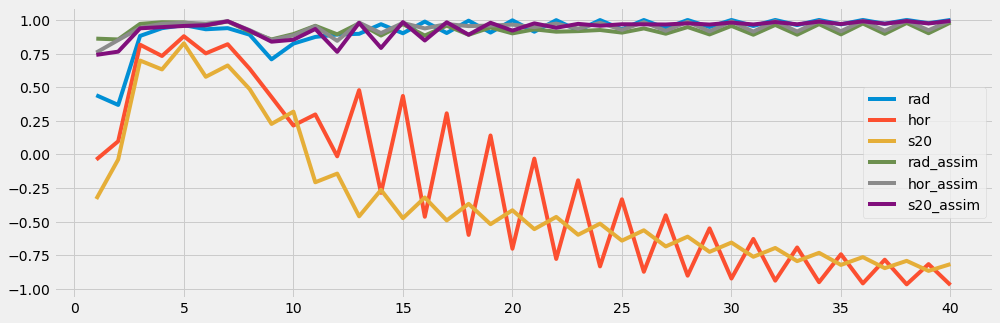

In [13]:
fig = plt.figure(figsize=(15,5))
#plt.plot(np.linspace(1,40,40),corr_dict["hor"])
for name, corr in corr_dict.items():
    plt.plot(np.linspace(1,40,40),corr,label=name)
plt.legend()
plt.show()